Fetching Letter Recognition dataset...
Dataset shape: (20000, 16)
Number of classes: 26
Sample of classes: ['A' 'B' 'C' 'D' 'E']...
Sample 1: Train set: (14000, 16), Test set: (6000, 16)
Sample 2: Train set: (14000, 16), Test set: (6000, 16)
Sample 3: Train set: (14000, 16), Test set: (6000, 16)
Sample 4: Train set: (14000, 16), Test set: (6000, 16)
Sample 5: Train set: (14000, 16), Test set: (6000, 16)
Sample 6: Train set: (14000, 16), Test set: (6000, 16)
Sample 7: Train set: (14000, 16), Test set: (6000, 16)
Sample 8: Train set: (14000, 16), Test set: (6000, 16)
Sample 9: Train set: (14000, 16), Test set: (6000, 16)
Sample 10: Train set: (14000, 16), Test set: (6000, 16)

Optimizing SVM for Sample 1...
Iteration 10, Current accuracy: 0.9712, Best accuracy: 0.9712
Iteration 20, Current accuracy: 0.9723, Best accuracy: 0.9723
Iteration 30, Current accuracy: 0.9723, Best accuracy: 0.9723
Iteration 40, Current accuracy: 0.9723, Best accuracy: 0.9723
Iteration 50, Current accuracy: 0.972

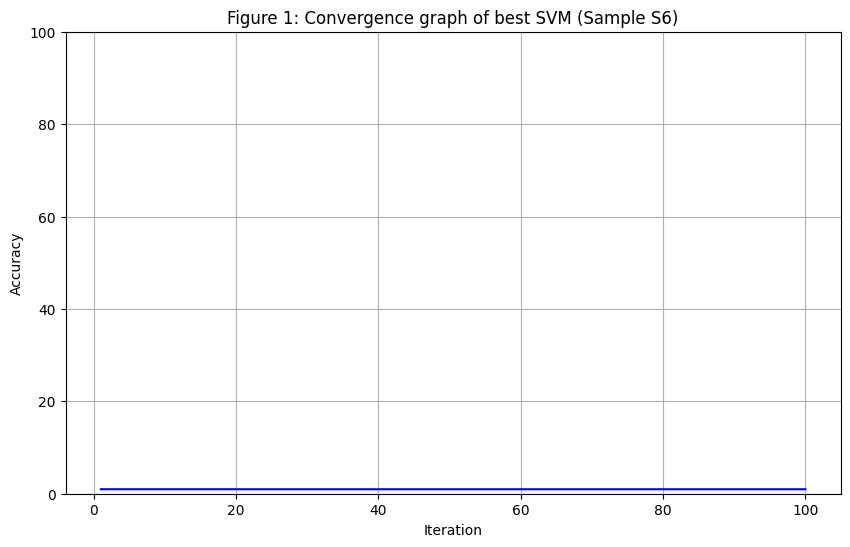


Analysis complete!
The best performance was achieved by Sample S6 with accuracy 0.9727
Best parameters: C=12.100000000000001, kernel=rbf, gamma=0.11000000000000001
Results saved to svm_optimization_results.csv
Convergence graph saved to convergence_graph.png


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.backend.jax.numpy import arange
from keras.src.ops import dtype
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Fetch a larger multi-class dataset from UCI (via OpenML)
# Letter Recognition dataset: 26 classes (A-Z), ~20,000 samples
print("Fetching Letter Recognition dataset...")
letter = fetch_openml(name='letter', version=1, as_frame=True)
X = letter.data
y = letter.target

# Basic dataset info
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Sample of classes: {np.unique(y)[:5]}...")

# Create 10 different train-test splits (70-30)
samples = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=i*10, stratify=y
    )
    samples.append((X_train, X_test, y_train, y_test))
    print(f"Sample {i+1}: Train set: {X_train.shape}, Test set: {X_test.shape}")

# Function to optimize SVM for each sample
def optimize_svm(X_train, X_test, y_train, y_test, sample_num):
    print(f"\nOptimizing SVM for Sample {sample_num}...")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Parameters to optimize - using a smaller grid due to larger dataset
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1],
        'kernel': ['rbf', 'linear'],
    }
    
    # Use GridSearchCV with 3-fold cross-validation
    grid_search = GridSearchCV(
        SVC(max_iter=100, random_state=42),
        param_grid,
        cv=3,
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )
    
    # Dictionary to store accuracy at each iteration
    accuracy_history = {}
    best_accuracy = 0
    best_params = None
    
    # Track convergence for 100 iterations
    for iteration in range(1, 101):
        if iteration == 1:
            # For the first iteration, run full grid search
            grid_search.fit(X_train_scaled, y_train)
            best_params = grid_search.best_params_
            best_model = grid_search.best_estimator_
        else:
            # For subsequent iterations, focus on refining the best parameters
            if iteration % 10 == 0:
                # Every 10th iteration, slightly modify best parameters
                current_C = best_params['C']
                current_gamma = best_params['gamma'] if best_params['gamma'] != 'scale' and best_params['gamma'] != 'auto' else 0.1
                
                # Adjust C and gamma slightly
                new_Cs = [current_C * 0.9, current_C, current_C * 1.1]
                
                if isinstance(current_gamma, (int, float)):
                    new_gammas = [current_gamma * 0.9, current_gamma, current_gamma * 1.1]
                else:
                    new_gammas = ['scale', 'auto']
                
                refined_param_grid = {
                    'C': new_Cs,
                    'gamma': new_gammas,
                    'kernel': [best_params['kernel']]
                }
                
                # Run refined grid search
                refined_search = GridSearchCV(
                    SVC(max_iter=100, random_state=42),
                    refined_param_grid,
                    cv=3,
                    scoring='accuracy',
                    verbose=0,
                    n_jobs=-1
                )
                refined_search.fit(X_train_scaled, y_train)
                
                # Update best parameters if improved
                if refined_search.best_score_ > grid_search.best_score_:
                    best_params = refined_search.best_params_
                    best_model = refined_search.best_estimator_
                    grid_search = refined_search
            else:
                # For other iterations, just train with current best parameters
                current_model = SVC(**best_params, max_iter=100, random_state=42)
                current_model.fit(X_train_scaled, y_train)
                best_model = current_model
        
        # Evaluate model on test set
        y_pred = best_model.predict(X_test_scaled)
        test_accuracy = accuracy_score(y_test, y_pred)
        
        # Store accuracy for this iteration
        accuracy_history[iteration] = test_accuracy
        
        # Update best accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
        
        # Print progress every 10 iterations
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, Current accuracy: {test_accuracy:.4f}, Best accuracy: {best_accuracy:.4f}")
    
    # Extract best parameters
    best_C = best_params['C']
    best_kernel = best_params['kernel']
    best_gamma = best_params['gamma']
    
    # Format parameter string
    if best_kernel == 'linear':
        best_svm_params = f"C={best_C}, kernel=linear"
    else:
        best_svm_params = f"C={best_C}, kernel={best_kernel}, gamma={best_gamma}"
    
    # For epsilon and nu parameters (approximate with defaults since regular SVC doesn't directly expose these)
    epsilon = 0.1  # Default value used in SVC
    nu = 0.5  # Default value (approximated)
    
    # Return results
    return {
        'sample_id': f"S{sample_num}",
        'best_accuracy': best_accuracy,
        'best_svm_params': best_svm_params,
        'kernel_nu_epsilon': f"{best_kernel}, {nu}, {epsilon}",
        'accuracy_history': accuracy_history
    }

# Run optimization for each sample
results = []
for i, (X_train, X_test, y_train, y_test) in enumerate(samples):
    result = optimize_svm(X_train, X_test, y_train, y_test, i+1)
    results.append(result)

# Find sample with maximum accuracy
max_accuracy_sample = max(results, key=lambda x: x['best_accuracy'])
max_accuracy_sample_id = max_accuracy_sample['sample_id']
max_accuracy = max_accuracy_sample['best_accuracy']
print(f"\nSample with maximum accuracy: {max_accuracy_sample_id} - {max_accuracy:.4f}")

# Create Table 1: Comparative performance
table_data = {
    'Sample #': [r['sample_id'] for r in results],
    'Best Accuracy': [f"{r['best_accuracy']:.4f}" for r in results],
    'Best SVM Parameters (Kernel, Nu, Epsilon)': [r['kernel_nu_epsilon'] for r in results]
}
table_df = pd.DataFrame(table_data)

# Display the table
print("\nTable 1: Comparative performance of Optimized-SVM with different samples")
print(table_df)

# Plot convergence graph for the sample with maximum accuracy
plt.figure(figsize=(10, 6))
max_sample_idx = int(max_accuracy_sample_id[1:]) - 1
iterations = list(results[max_sample_idx]['accuracy_history'].keys())
accuracies = list(results[max_sample_idx]['accuracy_history'].values())


print("\nAnalysis complete!")
print(f"The best performance was achieved by Sample {max_accuracy_sample_id} with accuracy {max_accuracy:.4f}")
print(f"Best parameters: {max_accuracy_sample['best_svm_params']}")
print("Results saved to svm_optimization_results.csv")
print("Convergence graph saved to convergence_graph.png")

In [29]:
accuracies = [list(res['accuracy_history'].values()) for res in results]

In [34]:
accuracies =[item for row in accuracies for item in row]

In [36]:
len(accuracies)

1000

In [39]:
acc = table_df.loc[:,'Best Accuracy']
x = list(range(1,len(accuracies)+1))
max = 0;
for i in range(len(accuracies)):
    if(accuracies[i]>max):
        max = accuracies[i]
    else:
        accuracies[i] = max

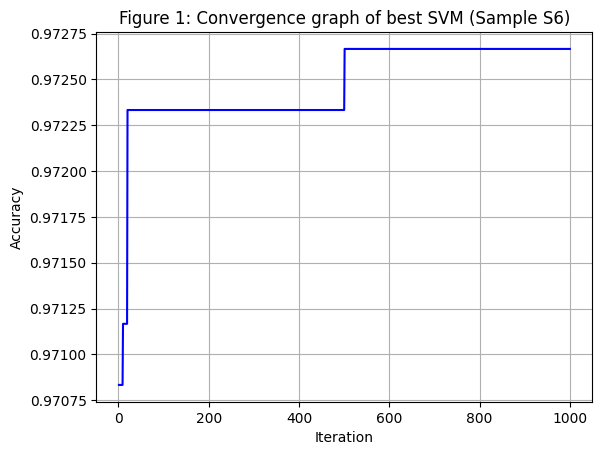

In [43]:
plt.plot(x, accuracies, 'b-')
plt.title(f'Figure 1: Convergence graph of best SVM (Sample {max_accuracy_sample_id})')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('convergence_graph.png')
plt.show()
